# Script for Pre-processing Dataset 

This script is created with intention to document steps in preparing dataset to do forest loss analysis. There are 3 outcomes generated from this script. They are:
1) Terrestrial Mammals Area of Habitat Based on IUCN Red List Category listed as Critically Endangered, Endangered, and Vulnerable (shp format)
2) Birds Area of Habitat from Birdllife with Red List Category from IUCN (shp format)
3) Planted Trees 2017 and 2020 (Following WRI definition) (tif format)

## Preparing Area of Habitat (AOH) Mammals & Birds

Dataset used here:
1) Terrestrial mammal area of habitat (IUCN) available at https://www.iucnredlist.org/resources/spatial-data-download (1 July 2025)
3) Bird Species' Area of Habitat (AOH) maps  requested from https://datazone.birdlife.org/contact-us/request-our-data (1 July 2025)
4) All species' habitat, minimum and maximum altitude are collected through IUCN Redlist Webpage by entering species' name one by one (July 2025), saved here with mammals_database.xls & bird_database.xls
5) Bird' IUCN redlist category available at https://datazone.birdlife.org/about-our-science/taxonomy (25 July 2025) named here as bird_iucn_taxonomy.xls file
6) Spatial Database of Planted Forest (WRI) https://www.wri.org/research/spatial-database-planted-trees-sdpt-version-2 (July 2025) downloaded from 
   https://gfw-files.s3.amazonaws.com/plantations/SDPT_v2.1/sdpt_v21_v09152024_public.gdb.zip, I export the shp using QGIS (I try to be consistent in using python but always fail when opening using fiona, using Rstudio took a very long, using Arcgis got warning issues)
8) Borneo Boundary (gadm41_Borneo_IDN_1) downloaded at https://gadm.org/ simplify vertex at 200m using ArcgisPro, explode and delete small-scattered islands except :
   - Maya Karimata island -1.1114594, 109.5900927 & -0.807859, 109.441845
   - Laut Selatan island -3.67704706, 116.1493258
   - Sebuku island -3.515927, 116.3694682
   - Mahakam Delta -0.663428, 117.401863
   - and Bulungan River Estuary 3.027885, 117.468919

In [1]:
import numpy as np
import matplotlib as plt
import geopandas as gpd
import os
import pandas as pd

In [3]:
os.getcwd()

'C:\\Users\\nooriza maharani\\Documents\\Dissertation'

In [5]:
borneo_boundary = gpd.read_file('gadm41_Borneo.shp')

In [7]:
mammal = gpd.read_file('MAMMALS_TERRESTRIAL_ONLY.shp')

In [8]:
bird = gpd.read_file('BOTW_2024_2.gpkg')

C:\Anaconda\Lib\site-packages\pyogrio\geopandas.py:275: UserWarning: More than one layer found in 'BOTW_2024_2.gpkg': 'all_species' (default), 'main_BL_HBW_Checklist_V9'. Specify layer parameter to avoid this warning.
  result = read_func(


In [6]:
import fiona

# List all layers in the GPKG file
layers = fiona.listlayers("BOTW_2024_2.gpkg")
print(layers)

['all_species', 'main_BL_HBW_Checklist_V9']


In [7]:
borneo_boundary.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
mammal.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
bird.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Clipping Mammals with Borneo Boundary

In [11]:
# Cek geometri yang tidak valid
invalid = mammal[~mammal.is_valid]
print(invalid)

      id_no             sci_name  presence  origin  seasonal      compiler  \
2535   9760  Helarctos malayanus         5       1         1  Graham Usher   
9831  41772         Sus barbatus         1       1         1          IUCN   

      yrcompiled                                           citation  \
2535        2017               Scotson, L. and Fredriksson, G. 2016   
9831        2017  IUCN (International Union for Conservation of ...   

     subspecies subpop  ... marine terrestria freshwater  SHAPE_Leng  \
2535       None   None  ...  false       true      false  298.047663   
9831   barbatus   None  ...  false       true      false  203.352979   

      SHAPE_Area           area  \
2535   28.227425  347094.755252   
9831   29.450292  362205.059335   

                                                habitat altitude max_alt  \
2535          Forest, Shrubland, Artificial/Terrestrial      1.0  3000.0   
9831  Forest, Wetlands (inland), Marine Neritic, Mar...      0.0     0.0   


In [10]:
# Select animals which presence is not extinct and resident through the year
mammals_filtered = mammal[(mammal['presence'] != 5) & (mammal['seasonal'] == 1)].copy()

In [13]:
len(mammals_filtered)

12450

In [11]:
from shapely.validation import make_valid

mammals_filtered["geometry"] = mammals_filtered["geometry"].apply(make_valid)
borneo_boundary["geometry"] = borneo_boundary["geometry"].apply(make_valid)

In [ ]:
mammals_borneo = gpd.clip(mammals_filtered, borneo_boundary)

In [ ]:
# Plot the clipped layer
mammals_borneo.plot(figsize=(10, 10), edgecolor='black', cmap='Set2')
plt.title("Clipped Mammals Layer")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
# Select animals where yrcompiled > 2000 and category as CR, VU, EN
mammals_threatened = mammals_borneo[
    (mammals_borneo['category'].isin(['VU', 'CR', 'EN'])) &
    (mammals_borneo['yrcompiled'] > 2000)
].copy()

In [ ]:
len(mammals_threatened)

In [ ]:
# Reproject to Southeast Asia Albers Equal Area (ESRI:102025) in square metres
mammals_borneo_proj = mammals_threatened.to_crs("ESRI:102025")

# Calculate area in square meters
mammals_borneo_proj['area_m2'] = mammals_borneo_proj.geometry.area
mammals_borneo_proj['area_km2'] = mammals_borneo_proj['area_m2'] / 1_000_000
# Remove small areas possibly the result of clipping process
mammals_borneo_proj = mammals_borneo_proj[mammals_borneo_proj['area_km2'] >= 80]

In [ ]:
print(mammals_borneo_proj.columns.to_list())

In [ ]:
# Sort by SHAPE_Area in descending order
mammals_sorted = mammals_borneo_proj.sort_values(by='area_km2', ascending=False)

# Display selected columns
#print(mammals_sorted[['sci_name', 'category', 'area_km2']])

In [ ]:
# Merged duplicate species name
# Sort to keep largest area per species
sorted_gdf = mammals_borneo_proj.sort_values('area_km2', ascending=False)

# Group and pick first (largest area)
mammals_merged = (
    sorted_gdf
    .groupby('sci_name', as_index=False)
    .agg({
        'category': lambda x: ', '.join(sorted(set(x))),
        'yrcompiled': lambda x: ', '.join(map(str, sorted(set(x)))),
        'area_km2': 'first',
        'geometry': 'first'
    })
)

# Convert to GeoDataFrame again
import geopandas as gpd
mammals_merged = gpd.GeoDataFrame(mammals_merged, geometry='geometry', crs=mammals_borneo_proj.crs)

In [ ]:
# Sort by SHAPE_Area in descending order
mammals_sort = mammals_merged.sort_values(by='sci_name', ascending=False)

# Display selected columns
#print(mammals_sort[['sci_name', 'category', 'yrcompiled', 'area_km2']])

In [ ]:
len(mammals_merged)

In [ ]:
iucn_data = pd.read_excel('mammals_database.xls')

In [ ]:
mammal_aoh = mammals_merged.merge(iucn_data, on = 'sci_name', how = 'left')

In [ ]:
mammal_aoh= mammal_aoh.dropna(subset=['max_alt'])

In [ ]:
len(mammal_aoh)

In [ ]:
#mammals_merged.to_file("mammals_merged.gpkg", driver = "GPKG")

In [ ]:
mammal_aoh.to_file("mammal_aoh.shp")

### Clipping Birds with Borneo Boundary

In [14]:
# Invalid Geometry
invalid_bird = bird[~bird.is_valid]
print(invalid1)

NameError: name 'invalid1' is not defined

In [ ]:
from shapely.validation import make_valid

bird["geometry"] = bird["geometry"].apply(make_valid)

In [ ]:
bird_borneo = gpd.clip(bird, borneo_boundary)

In [ ]:
bird_borneo.columns

In [ ]:
# Plot the clipped layer
bird_borneo.plot(figsize=(10, 10), edgecolor='black', cmap='Set2')
plt.title("Clipped bird Layer")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
# Select animals which presence is not extinct and resident through the year
bird_borneo_f = bird_borneo[(bird_borneo['presence'] != 5) & (bird_borneo['seasonal'] == 1) & (bird_borneo['yrcompiled'] > 2000)].copy()

In [ ]:
iucn_data_bird = pd.read_excel('birds_iucn_taxonomy.xls')

In [ ]:
bird_aoh = bird_borneo_f.merge(iucn_data_bird, on = 'sci_name', how = 'left')

In [ ]:
birds_threatened_aoh = bird_aoh[bird_aoh['iucn_category'].isin(['VU', 'CR', 'EN'])].copy()

In [ ]:
len(birds_threatened_aoh)

In [ ]:
# Reproject to Southeast Asia Albers Equal Area (ESRI:102025) in square metres
bird_proj = birds_threatened_aoh.to_crs("ESRI:102025")

# Calculate area in square meters
bird_proj['area_m2'] = bird_proj.geometry.area
bird_proj['area_km2'] = bird_proj['area_m2'] / 1_000_000

In [ ]:
# Merged duplicate species name
# Sort to keep largest area per species
bird_gdf = bird_proj.sort_values('area_km2', ascending=False)

# Group and pick first (largest area)
bird_merged = (
    bird_gdf
    .groupby('sci_name', as_index=False)
    .agg({
        'iucn_category': lambda x: ', '.join(sorted(set(x))),
        'yrcompiled': lambda x: ', '.join(map(str, sorted(set(x)))),
        'area_km2': 'first',
        'geometry': 'first'
    })
)

# Convert to GeoDataFrame again
import geopandas as gpd
bird_merged = gpd.GeoDataFrame(bird_merged, geometry='geometry', crs=bird_proj.crs)

In [ ]:
# Sort by SHAPE_Area in descending order
bird_sort = bird_merged.sort_values(by='area_km2', ascending=False)

# Display selected columns
print(bird_sort[['sci_name', 'iucn_category', 'yrcompiled', 'area_km2']])

In [ ]:
altitude = pd.read_excel('birds_database.xls')

In [ ]:
aoh_bird = bird_merged.merge(altitude, on = 'sci_name', how = 'left')

In [ ]:
print(aoh_bird)

In [ ]:
aoh_bird= aoh_bird.dropna(subset=['max_alt'])
len(aoh_bird)

In [ ]:
#aoh_bird.to_file("aoh_bird.shp")

In [23]:
#Merging Mammal and Birds

# Identify common columns (excluding geometry)
common_cols = list(set(aoh_bird.columns).intersection(set(mammal_aoh.columns)))
common_cols = [col for col in common_cols if col != 'geometry']

# Align both GeoDataFrames
bird_aligned = aoh_bird[common_cols + ['geometry']]
mammal_aligned = mammal_aoh[common_cols + ['geometry']]

# Merge them
merged = pd.concat([bird_aligned, mammal_aligned], ignore_index=True)
merged_gdf = gpd.GeoDataFrame(merged, crs=aoh_bird.crs)

# Save the merged shapefile
merged_gdf.to_file("merged_aoh.shp")

In [5]:
import geopandas as gpd
m = gpd.read_file("merged_aoh.shp")

In [9]:
m_proj = m.to_crs("EPSG:3857")

In [11]:
m_proj["area_m2"] = m_proj.geometry.area

In [13]:
m_proj = m_proj.assign(area_m2=m_proj.geometry.area)
m_proj_sorted = m_proj.sort_values("area_m2", ascending=True)

In [15]:
m_proj_sorted[["area_m2", "geometry"]]

,area_m2,geometry
28,1.884933e+08,"POLYGON ((12269470.387 114461.137, 12269376.12..."
18,6.305049e+08,"MULTIPOLYGON (((12829022.063 -278063.881, 1282..."
47,6.930491e+08,"POLYGON ((12445386.6 -391342.969, 12446326.137..."
35,9.390332e+08,"MULTIPOLYGON (((13052638.057 486384.454, 13052..."
36,1.101179e+09,"POLYGON ((12925098.459 -440680.002, 12925310.3..."
...,...,...
53,5.327136e+11,"MULTIPOLYGON (((13093263.774 463877.218, 13093..."
6,5.362795e+11,"MULTIPOLYGON (((13093275.664 463888.608, 13093..."
2,5.362798e+11,"MULTIPOLYGON (((13093275.664 463888.608, 13093..."
22,5.362798e+11,"MULTIPOLYGON (((13093275.664 463888.608, 13093..."


## Working with Planted Forest Dataset

What I do here:
1) Note: There are several invalid geomtries for this SDPT dataset. I try to use shapely and initially wanted to do clipping in python, but the operation takes too long, so I used GIS desktop software to clip the data into Borneo Boundary
2) Perform filtering trees that are planted before and equal to year 2017 as a planted trees for 2017 and use the SDPT V21 official dataset in 2020 as planted trees for 2020.
3) I rasterize them here with output of 30 x 30 pixels, matching Hansen Forest Loss Dataset and compressed them before uploaded into GEE asset

In [4]:
os.getcwd()

'C:\\Users\\nooriza maharani\\Documents\\Dissertation'

In [5]:
#sdpt = gpd.read_file("sdpt_idn_plant_v21.shp")

In [14]:
# Invalid Geometry
invalid_sdpt = sdpt[~sdpt.is_valid]
print(invalid_sdpt)

        OBJECTID final_id iso3 iso2    country  \
88          89.0   IDN_38  IDN   ID  Indonesia   
89          90.0   IDN_38  IDN   ID  Indonesia   
102        103.0   IDN_38  IDN   ID  Indonesia   
105        106.0   IDN_38  IDN   ID  Indonesia   
107        108.0   IDN_38  IDN   ID  Indonesia   
...          ...      ...  ...  ...        ...   
953347  953348.0  IDN_203  IDN   ID  Indonesia   
953355  953356.0  IDN_203  IDN   ID  Indonesia   
953359  953360.0  IDN_203  IDN   ID  Indonesia   
953361  953362.0  IDN_203  IDN   ID  Indonesia   
953365  953366.0  IDN_203  IDN   ID  Indonesia   

                                               originalNa  originalCo  \
88      Large industrial plantation, Oil palm, transpa...          38   
89      Large industrial plantation, Oil palm, transpa...          38   
102     Large industrial plantation, Oil palm, transpa...          38   
105     Large industrial plantation, Oil palm, transpa...          38   
107     Large industrial plantatio

In [7]:
# RUn this but takes too long, so I prefer using QGIS to clip the planted forest
#from shapely.validation import make_valid
#sdpt["geometry"] = sdpt["geometry"].apply(make_valid)


KeyboardInterrupt



In [9]:
borneo_sdpt = gpd.read_file('planted_crops.shp')

In [11]:
borneo_sdpt.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
# Reproject to Southeast Asia Albers Equal Area (ESRI:102025) in square metres
borneo_sdpt_proj = borneo_sdpt.to_crs("ESRI:102025")

In [18]:
borneo_sdpt_proj.columns

Index(['FID', 'OBJECTID', 'final_id', 'iso3', 'iso2', 'country', 'originalNa',
       'originalCo', 'finalCode', 'vernacName', 'sciName', 'simpleName',
       'sciName1', 'sciName2', 'sciName3', 'sciName4', 'sciName5', 'sciName6',
       'sciName7', 'sciName8', 'sciName9', 'sciName10', 'sciName11',
       'sciName12', 'sciName13', 'simpleType', 'leafStatus', 'leafType',
       'woodType', 'sizeCatego', 'ownership', 'reference', 'imageryYea',
       'method', 'removalFac', 'removalF_1', 'removalF_2', 'removalF_3',
       'removalF_4', 'removalF_5', 'removalF_6', 'removalF_7', 'plantedYea',
       'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')

In [20]:
len(borneo_sdpt_proj)

706313

In [24]:
sdpt_2017 = borneo_sdpt_proj[borneo_sdpt_proj['plantedYea'] <= 2017]

In [26]:
len(sdpt_2017)

646733

In [28]:
#sdpt_2017.to_file('sdpt_2017.shp')
#borneo_sdpt_proj.to_file('sdpt_2020.shp')

In [32]:
pip install geopandas rasterio rasterio.features

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement rasterio.features (from versions: none)
ERROR: No matching distribution found for rasterio.features


In [34]:
# Changing vector file into raster in 30x30
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import numpy as np

# Define raster resolution and bounds
resolution = 30  # in the units of  CRS (meters)
bounds = sdpt_2017.total_bounds  # [minx, miny, maxx, maxy]

width = int((bounds[2] - bounds[0]) / resolution)
height = int((bounds[3] - bounds[1]) / resolution)

transform = from_bounds(*bounds, width=width, height=height)

# Create (geometry, value) pairs — all values set to 1 (plantation)
shapes = [(geom, 1) for geom in sdpt_2017.geometry]

# Rasterize
raster = rasterize(
    shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,  # 0 = no plantation
    dtype='uint8'
)

# Save as GeoTIFF
with rasterio.open(
    'plantation_2017.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype='uint8',
    crs=sdpt_2017.crs,
    transform=transform,
) as dst:
    dst.write(raster, 1)


In [38]:
# Changing vector file into raster in 30x30
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import numpy as np

# Define raster resolution and bounds
resolution = 30  # in the units of your CRS (e.g., meters)
bounds = borneo_sdpt_proj.total_bounds  # [minx, miny, maxx, maxy]

width = int((bounds[2] - bounds[0]) / resolution)
height = int((bounds[3] - bounds[1]) / resolution)

transform = from_bounds(*bounds, width=width, height=height)

# Create (geometry, value) pairs — all values set to 1 (plantation)
shapes = [(geom, 1) for geom in borneo_sdpt_proj.geometry]

# Rasterize
raster = rasterize(
    shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,  # 0 = no plantation
    dtype='uint8'
)

# Save as GeoTIFF
with rasterio.open(
    'plantation_2020.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype='uint8',
    crs=sdpt_2017.crs,
    transform=transform,
) as dst:
    dst.write(raster, 1)


In [42]:
# Compress the geotiff output
!gdal_translate -co COMPRESS=LZW -co TILED=YES plantation_2017.tif output_compressed.tif

Input file size is 40582, 29940
0...10...20...30...40...50...60...70...80...90...100 - done in 00:00:11.


In [44]:
# Check whether the original raster similar in shape and value with compressed raster
with rasterio.open("plantation_2017.tif") as src1, rasterio.open("output_compressed.tif") as src2:
    data1 = src1.read(1)
    data2 = src2.read(1)

    print("Same shape?", data1.shape == data2.shape)
    print("All values equal?", np.array_equal(data1, data2))


Same shape? True
All values equal? True


In [49]:
# Compress the geotiff output
!gdal_translate -co COMPRESS=LZW -co TILED=YES plantation_2020.tif output_compressed_2020.tif

Input file size is 40582, 29940
0...10...20...30...40...50...60...70...80...90...100 - done in 00:00:12.


In [59]:
# Check whether the original raster similar in shape and value with compressed raster
with rasterio.open("plantation_2020.tif") as src1, rasterio.open("output_compressed_2020.tif") as src2:
    data1 = src1.read(1)
    data2 = src2.read(1)

    print("Same shape?", data1.shape == data2.shape)
    print("All values equal?", np.array_equal(data1, data2))


Same shape? True
All values equal? True


# Script for Visualizing the Result

In [15]:
os.getcwd()

'C:\\Users\\nooriza maharani\\Documents\\Dissertation\\Forestloss'

In [41]:
df = pd.read_csv('Remaining_Habitat_Trend_CR_EN_VU_by_period_2001_20241.csv')
df.head(10)

,system:index,area_ha,end,period,start,threat,.geo
0,1_1_2_0,2.815652e+07,2005.0,2001.0_2005.0,2001.0,CR,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,1_1_2_1,2.704437e+07,2010.0,2006.0_2010.0,2006.0,CR,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,1_1_2_2,2.565900e+07,2015.0,2011.0_2015.0,2011.0,CR,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,1_1_2_3,2.461572e+07,2020.0,2016.0_2020.0,2016.0,CR,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,1_1_2_4,2.419172e+07,2024.0,2021.0_2024.0,2021.0,CR,"{""type"":""MultiPoint"",""coordinates"":[]}"
5,1_2_0,2.830508e+07,2005.0,2001.0_2005.0,2001.0,EN,"{""type"":""MultiPoint"",""coordinates"":[]}"
6,1_2_1,2.718528e+07,2010.0,2006.0_2010.0,2006.0,EN,"{""type"":""MultiPoint"",""coordinates"":[]}"
7,1_2_2,2.578396e+07,2015.0,2011.0_2015.0,2011.0,EN,"{""type"":""MultiPoint"",""coordinates"":[]}"
8,1_2_3,2.472968e+07,2020.0,2016.0_2020.0,2016.0,EN,"{""type"":""MultiPoint"",""coordinates"":[]}"
9,1_2_4,2.430283e+07,2024.0,2021.0_2024.0,2021.0,EN,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [47]:
# First, filter area_ha for the two periods
area_end = df.loc[df['period'] == '2021.0_2024.0', ['threat', 'area_ha']].set_index('threat')
area_start = df.loc[df['period'] == '2001.0_2005.0', ['threat', 'area_ha']].set_index('threat')

# Join on threat to have start and end areas side-by-side
combined = area_start.join(area_end, lsuffix='_start', rsuffix='_end').dropna()

# Calculate remaining area percentage
combined['remaining_area_percent'] = ((combined['area_ha_end'] - combined['area_ha_start']) / combined['area_ha_start']) * 100

print(combined['remaining_area_percent'].round(2))

threat
CR   -14.08
EN   -14.14
VU   -14.14
Name: remaining_area_percent, dtype: float64


In [31]:
print(df_filtered['start'].unique())

[2001.]


## Pixel of Bivariate Map

In [31]:
pixel = gpd.read_file('High_Bivariate_Pixels_v8.shp')

In [33]:
pixel.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [35]:
# Reproject to Southeast Asia Albers Equal Area (ESRI:102025) in square metres
pixel_proj = pixel.to_crs("ESRI:102025")

In [37]:
merged = pixel_proj.dissolve()

In [39]:
aoh_bird = gpd.read_file('aoh_bird.shp')
mammal_aoh = gpd.read_file('mammal_aoh.shp')

In [41]:
bird_species= gpd.clip(aoh_bird, pixel_proj)
mammal_species= gpd.clip(mammal_aoh, pixel_proj)

In [71]:
sorted_species = bird_species[['sci_name', 'category', 'min_alt','max_alt','habitat']].sort_values(by='category')
print(sorted_species)

                      sci_name category  min_alt  max_alt  \
14            Lophura pyronota       EN      0.0    300.0   
21  Rhabdotorrhinus corrugatus       EN      0.0     30.0   
10         Geokichla interpres       EN     80.0   1000.0   
9               Ciconia stormi       EN      0.0    200.0   
5         Berenicornis comatus       EN      0.0    600.0   
24           Setornis criniger       VU      0.0   1000.0   
25             Treron capellei       VU      0.0    600.0   
23            Rollulus rouloul       VU      0.0   1200.0   
20   Ptilocichla leucogrammica       VU      0.0    600.0   
19     Pityriasis gymnocephala       VU      0.0    600.0   
11       Harpactes orrhophaeus       VU      0.0    600.0   
8         Centropus rectunguis       VU      0.0    600.0   
1      Anthracoceros malayanus       VU      0.0    200.0   
13              Lophura ignita       VU     10.0   1000.0   
3       Batrachostomus auritus       VU      0.0    300.0   
15          Melanoperdix

In [73]:
sorted_species1 = mammal_species[['sci_name', 'category','min_alt','max_alt', 'habitat']].sort_values(by='category')
print(sorted_species1)


                     sci_name category  min_alt  max_alt  \
29      Presbytis chrysomelas       CR      0.0    100.0   
6    Dicerorhinus sumatrensis       CR      0.0   2500.0   
2               Bos javanicus       CR      0.0   2100.0   
27             Pongo pygmaeus       CR      0.0    500.0   
16             Manis javanica       CR      0.0   1700.0   
11       Hylobates albibarbis       EN      0.0   1200.0   
12         Hylobates funereus       EN    100.0   1700.0   
3              Catopuma badia       EN      0.0    800.0   
22           Nasalis larvatus       EN      0.0    350.0   
34  Pteromyscus pulverulentus       EN      0.0   3000.0   
33           Presbytis sabana       EN     50.0   2000.0   
8             Elephas maximus       EN      0.0   3000.0   
14        Macaca fascicularis       EN      0.0   2500.0   
35          Pteropus vampyrus       EN      0.0   1200.0   
5          Cynogale bennettii       EN      0.0   1370.0   
15          Macaca nemestrina       EN  

In [75]:
len(bird_species)

26

In [77]:
len(mammal_species)

30

In [87]:
import pandas as pd

# Define the order of IUCN categories (adjust if needed)
category_order = ['CR', 'EN', 'VU']

# Select columns and copy
df = bird_species[['sci_name', 'category']].copy()

# Rename for clarity
df = df.rename(columns={'sci_name': 'Scientific Name', 'category': 'IUCN Category'})

# Set category dtype with order
df['IUCN Category'] = pd.Categorical(df['IUCN Category'], categories=category_order, ordered=True)

# Sort by the IUCN Category
df_sorted = df.sort_values(by='IUCN Category').reset_index(drop=True)

print(df_sorted)

               Scientific Name IUCN Category
0             Lophura pyronota            EN
1   Rhabdotorrhinus corrugatus            EN
2          Geokichla interpres            EN
3               Ciconia stormi            EN
4         Berenicornis comatus            EN
5            Setornis criniger            VU
6              Treron capellei            VU
7             Rollulus rouloul            VU
8    Ptilocichla leucogrammica            VU
9      Pityriasis gymnocephala            VU
10       Harpactes orrhophaeus            VU
11        Centropus rectunguis            VU
12     Anthracoceros malayanus            VU
13              Lophura ignita            VU
14      Batrachostomus auritus            VU
15          Melanoperdix niger            VU
16        Carpococcyx radiceus            VU
17        Rhyticeros undulatus            VU
18              Nisaetus nanus            VU
19          Buceros rhinoceros            VU
20      Belocercus longicaudus            VU
21        

In [89]:
import pandas as pd

# Define the order of IUCN categories (adjust if needed)
category_order = ['CR', 'EN', 'VU']

# Select columns and copy
df = mammal_species[['sci_name', 'category']].copy()

# Rename for clarity
df = df.rename(columns={'sci_name': 'Scientific Name', 'category': 'IUCN Category'})

# Set category dtype with order
df['IUCN Category'] = pd.Categorical(df['IUCN Category'], categories=category_order, ordered=True)

# Sort by the IUCN Category
df_sorted = df.sort_values(by='IUCN Category').reset_index(drop=True)

print(df_sorted)


              Scientific Name IUCN Category
0       Presbytis chrysomelas            CR
1    Dicerorhinus sumatrensis            CR
2               Bos javanicus            CR
3              Pongo pygmaeus            CR
4              Manis javanica            CR
5        Hylobates albibarbis            EN
6          Hylobates funereus            EN
7              Catopuma badia            EN
8            Nasalis larvatus            EN
9   Pteromyscus pulverulentus            EN
10           Presbytis sabana            EN
11            Elephas maximus            EN
12        Macaca fascicularis            EN
13          Pteropus vampyrus            EN
14         Cynogale bennettii            EN
15          Macaca nemestrina            EN
16           Nycticebus kayan            VU
17       Nycticebus borneanus            VU
18   Rheithrosciurus macrotis            VU
19            Neofelis diardi            VU
20        Presbytis rubicunda            VU
21      Nycticebus menagensis   

## Script to compress BHI components raster

In [63]:
borneo_boundary = gpd.read_file('gadm41_Borneo.shp')

In [69]:
import rasterio

# List of raster file paths
raster_paths = [
    "BILBI_P_BHIv2_Species_2000.tif",
    "BILBI_P_BHIv2_Species_2005.tif",
    "BILBI_P_BHIv2_Species_2010.tif",
    "BILBI_P_BHIv2_Species_2015.tif",
    "BILBI_P_BHIv2_Species_2020.tif"
]

# Loop through each raster file
for path in raster_paths:
    print(f"\n--- Reading: {path} ---")
    
    try:
        with rasterio.open(path) as src:
            print("Raster Info:")
            print(" - CRS:", src.crs)
            print(" - Width:", src.width)
            print(" - Height:", src.height)
            print(" - Number of Bands:", src.count)
            print(" - Data Type:", src.dtypes[0])
            print(" - Bounds:", src.bounds)
            
            # Read first band
            band1 = src.read(1)

            # Check pixel value range
            print(" - Min Value:", band1.min())
            print(" - Max Value:", band1.max())

    except Exception as e:
        print(f"Failed to read {path}: {e}")


--- Reading: BILBI_P_BHIv2_Species_2000.tif ---
Raster Info:
 - CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
 - Width: 43200
 - Height: 18000
 - Number of Bands: 1
 - Data Type: float32
 - Bounds: BoundingBox(left=-180.0, bottom=-60.0, right=179.99999999999858, top=89.9999999999994)
 - Min Value: -3.402823e+38
 - Max Value: 0.99730045

--- Reading: BILBI_P_BHIv2_Species_2005.tif ---
Raster Info:
 - CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
 - Width: 43200
 - Height: 18000
 - Number of Bands: 1
 - Data Type: float32
 - Bounds: BoundingBox(left=-180.0, bottom=-60.0, right=179.99999999999858, top=89.9999999999994)
 - Min Value: -

In [71]:
import rasterio
from rasterio.mask import mask

# List of raster files to clip
raster_files = [
 "BILBI_P_BHIv2_Species_2000.tif",
    "BILBI_P_BHIv2_Species_2005.tif",
    "BILBI_P_BHIv2_Species_2010.tif",
    "BILBI_P_BHIv2_Species_2015.tif",
    "BILBI_P_BHIv2_Species_2020.tif"
]

# Extract geometry in GeoJSON format
geoms = borneo_boundary.geometry.values
geometry = [geoms[0]]

# Clip all rasters in the list
for raster_path in raster_files:
    output_path = f"clipped_{os.path.basename(raster_path)}"
    print(f"Clipping: {raster_path} -> {output_path}")
    
    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, geometry, crop=True)
        
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)


Clipping: BILBI_P_BHIv2_Species_2000.tif -> clipped_BILBI_P_BHIv2_Species_2000.tif
Clipping: BILBI_P_BHIv2_Species_2005.tif -> clipped_BILBI_P_BHIv2_Species_2005.tif
Clipping: BILBI_P_BHIv2_Species_2010.tif -> clipped_BILBI_P_BHIv2_Species_2010.tif
Clipping: BILBI_P_BHIv2_Species_2015.tif -> clipped_BILBI_P_BHIv2_Species_2015.tif
Clipping: BILBI_P_BHIv2_Species_2020.tif -> clipped_BILBI_P_BHIv2_Species_2020.tif


In [73]:
import rasterio

# List of clipped rasters (already generated)
clipped_files = [
    "clipped_BILBI_P_BHIv2_Species_2000.tif",
    "clipped_BILBI_P_BHIv2_Species_2005.tif",
    "clipped_BILBI_P_BHIv2_Species_2010.tif",
    "clipped_BILBI_P_BHIv2_Species_2015.tif",
    "clipped_BILBI_P_BHIv2_Species_2020.tif"
]

# Open the first file to get metadata
with rasterio.open(clipped_files[0]) as src:
    meta = src.meta.copy()

# Update metadata for a multi-band file
meta.update(count=len(clipped_files))

# Create the stacked output file
with rasterio.open('species_stack.tif', 'w', **meta) as dst:
    for band_idx, file in enumerate(clipped_files, start=1):
        with rasterio.open(file) as src:
            dst.write(src.read(1), band_idx)  # Write each as a new band

## Correlation of BII 2020 and Forest Loss

In [3]:
dataset = pd.read_csv('Random_BII_ForestLoss_Samples_100m.csv')

In [24]:
dataset.tail(7)

,system:index,bii_2020,forest_loss_100m,.geo
2956,4990_0,0.996103,0.00,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2957,4991_0,0.791824,0.80,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2958,4992_0,0.999334,0.00,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2959,4993_0,0.935296,0.00,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2960,4994_0,0.992126,0.00,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2961,4995_0,0.995857,0.00,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2962,4999_0,0.924274,0.05,"{""geodesic"":false,""type"":""Point"",""coordinates""..."


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2963 entries, 0 to 2962
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   system:index      2963 non-null   object 
 1   bii_2020          2963 non-null   float64
 2   forest_loss_100m  2963 non-null   float64
 3   .geo              2963 non-null   object 
dtypes: float64(2), object(2)
memory usage: 92.7+ KB


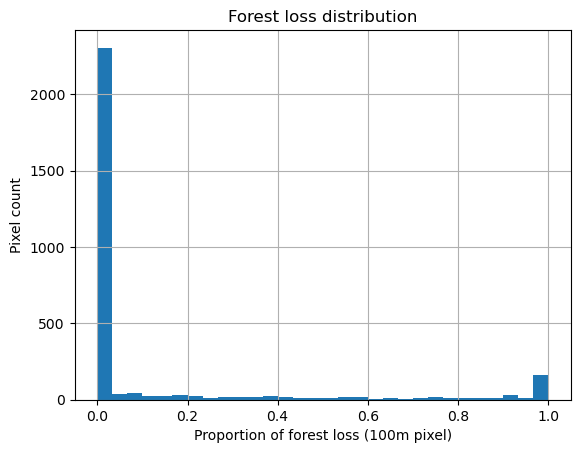

In [7]:
import matplotlib.pyplot as plt

# Histogram of forest loss proportions
dataset['forest_loss_100m'].hist(bins=30)
plt.xlabel('Proportion of forest loss (100m pixel)')
plt.ylabel('Pixel count')
plt.title('Forest loss distribution')
plt.show()


### Pearson

In [9]:
from scipy.stats import pearsonr

# Extract the variables
x = dataset['forest_loss_100m']
y = dataset['bii_2020']

# Compute Pearson correlation and p-value
r, p = pearsonr(x, y)

print(f"Pearson r     = {r:.4f}")
print(f"p-value       = {p:.4e}")


Pearson r     = -0.6770
p-value       = 0.0000e+00


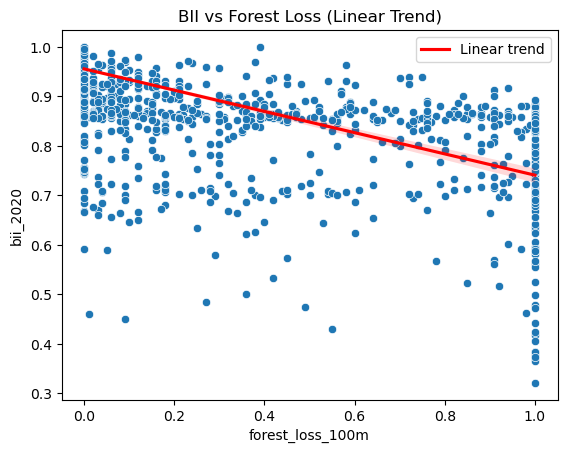

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x='forest_loss_100m', y='bii_2020', data=dataset)
sns.regplot(x='forest_loss_100m', y='bii_2020', data=dataset, scatter=False, color='red', label='Linear trend')
plt.legend()
plt.title("BII vs Forest Loss (Linear Trend)")
plt.show()


In [17]:
import statsmodels.api as sm

# Add a constant term so we fit an intercept
x_with_const = sm.add_constant(x)

# Fit the OLS model
model = sm.OLS(y, x_with_const).fit()

# Print the regression summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               bii_2020   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     2506.
Date:                Wed, 06 Aug 2025   Prob (F-statistic):               0.00
Time:                        11:24:31   Log-Likelihood:                 3817.6
No. Observations:                2963   AIC:                            -7631.
Df Residuals:                    2961   BIC:                            -7619.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.9553      0.001  

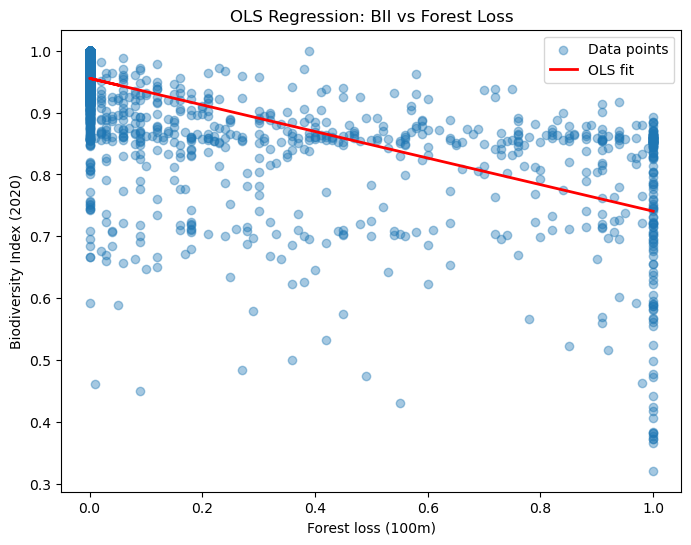

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# Prepare data
X = dataset['forest_loss_100m']
y = dataset['bii_2020']

# Fit the OLS model
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()

# Predicted values
y_pred = model.predict(X_with_const)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(X, y, alpha=0.4, label='Data points')
plt.plot(X, y_pred, color='red', linewidth=2, label='OLS fit')
plt.xlabel('Forest loss (100m)')
plt.ylabel('Biodiversity Index (2020)')
plt.title('OLS Regression: BII vs Forest Loss')
plt.legend()
plt.show()
